<a href="https://colab.research.google.com/github/RQC-Robotics/PointClouds/blob/main/My_PC_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install 'torch==1.6.0+cu101' -f https://download.pytorch.org/whl/torch_stable.html
!pip install 'torchvision==0.7.0+cu101' -f https://download.pytorch.org/whl/torch_stable.html
!pip install 'pytorch3d==0.2.5'

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 708.0 MB 10 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.6.0+cu101 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.6.0+cu101 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.6.0+cu101 which is incompatible.
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 5.9 MB 41.3 MB/s 
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Unin

In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.optim as optim

In [3]:
batch_size = 32
use_GPU = True # use GPU, False to use CPU
latent_size = 120 # bottleneck size of the Autoencoder model

In [4]:
from torch.utils.data import Dataset, DataLoader, random_split

class ReadDataset(Dataset):
    def __init__(self,  source):
     
        self.data = torch.from_numpy(source).float()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]

def RandomSplit(datasets, train_set_percentage):
    lengths = [int(len(datasets)*train_set_percentage), len(datasets)-int(len(datasets)*train_set_percentage)]
    return random_split(datasets, lengths)

def GetDataLoaders(npArray, batch_size, train_set_percentage = 0.9, shuffle=True, num_workers=0, pin_memory=True):
    
    pc = ReadDataset(npArray)

    train_set, test_set = RandomSplit(pc, train_set_percentage)

    train_loader = DataLoader(train_set, shuffle=shuffle, num_workers=num_workers, batch_size=batch_size, pin_memory=pin_memory)
    test_loader = DataLoader(test_set, shuffle=shuffle, num_workers=num_workers, batch_size=batch_size, pin_memory=pin_memory)
    
    return train_loader, test_loader

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
def cut_z (arr, z_min):
  
  for i in range (arr.shape[0]):
    z = np.array([arr[i][j][2] for j in range(arr[i].shape[0])])
    arr[i] = arr[i][z > z_min]
  return np.array(arr)

def cut_point_num (arr, point_num):
  new_arr = []
  for i in range (arr.shape[0]):
    if (arr[i].shape[0] >= point_num):
        new_arr.append(arr[i][0:point_num])
  return np.array(new_arr)

In [7]:
pc_array = np.load("drive/MyDrive/Robotic files/res1.npy", allow_pickle=True)
pc_array = cut_z(pc_array, -0.30)
pc_array = cut_point_num(pc_array, 800)

In [8]:
print(pc_array.shape)


train_loader, test_loader = GetDataLoaders(npArray=pc_array, batch_size=batch_size)

point_size = len(train_loader.dataset[0])
print(point_size)

(9996, 800, 3)
800


In [9]:
import plotly.graph_objects as go

def draw_pc (pc_arr):

    x = np.array([pc_arr[i][0] for i in range(pc_arr.shape[0])])
    y = np.array([pc_arr[i][1] for i in range(pc_arr.shape[0])])
    z = np.array([pc_arr[i][2] for i in range(pc_arr.shape[0])])

    fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(
        size=2,
        color=z,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
        ))])
  
    fig.show()

In [10]:
draw_pc(pc_array[0])

In [11]:

import torch
import torch.nn as nn
import torch.nn.functional as F

'''
PointNet AutoEncoder
Learning Representations and Generative Models For 3D Point Clouds
https://arxiv.org/abs/1707.02392
'''

class PointCloudAE(nn.Module):
    def __init__(self, point_size, latent_size):
        super(PointCloudAE, self).__init__()
        
        self.latent_size = latent_size
        self.point_size = point_size
        
        self.conv1 = torch.nn.Conv1d(3, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, self.latent_size, 1)



        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)


        self.bn3 = nn.BatchNorm1d(self.latent_size)
        
        self.dec1 = nn.Linear(self.latent_size,256)
        self.dec2 = nn.Linear(256,256)
        self.dec3 = nn.Linear(256,self.point_size*3)

    def encoder(self, x): 
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, self.latent_size)
        return x
    
    def decoder(self, x):
        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = self.dec3(x)
        return x.view(-1, self.point_size, 3)
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [12]:
net = PointCloudAE(point_size,latent_size)


if(use_GPU):
    device = torch.device("cuda:0")
    if torch.cuda.device_count() > 1: # if there are multiple GPUs use all
        net = torch.nn.DataParallel(net)
else:
    device = torch.device("cpu")

net = net.to(device)

In [13]:
from pytorch3d.loss import chamfer_distance # chamfer distance for calculating point cloud distance

optimizer = optim.Adam(net.parameters(), lr=0.0003, weight_decay=0.0)

In [14]:
def train_epoch():
    epoch_loss = 0
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        
        data = data.to(device)
        output = net(data.permute(0,2,1)) # transpose data for NumberxChannelxSize format
        loss, _ = chamfer_distance(data, output) 
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss/i

In [15]:
def test_batch(data): # test with a batch of inputs
    with torch.no_grad():
        data = data.to(device)
        output = net(data.permute(0,2,1))
        loss, _ = chamfer_distance(data, output)
        
    return loss.item(), output.cpu()

In [16]:
def test_epoch(): # test with all test set
    with torch.no_grad():
        epoch_loss = 0
        for i, data in enumerate(test_loader):
            loss, output = test_batch(data)
            epoch_loss += loss

    return epoch_loss/(i + 0.01)

epoch 0 train loss : 0.03459507535838147 test loss : 0.017018692182921777 epoch time : 1.5931637287139893



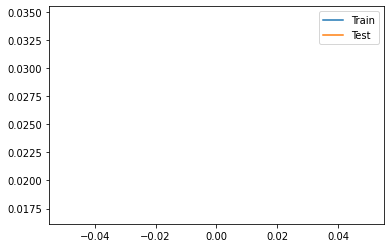

epoch 10 train loss : 0.006468044317184924 test loss : 0.00696564946168663 epoch time : 1.4594619274139404



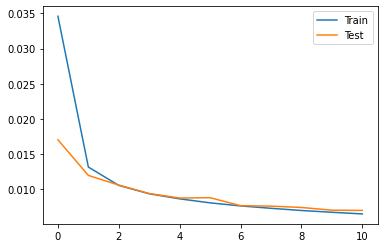

epoch 20 train loss : 0.005178860274352319 test loss : 0.005726775206128115 epoch time : 1.4794540405273438



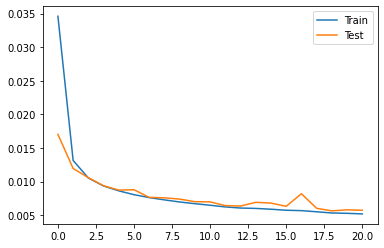

epoch 30 train loss : 0.004571239130896287 test loss : 0.004909415115169539 epoch time : 1.4576995372772217



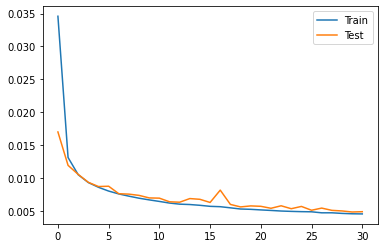

epoch 40 train loss : 0.0042134635233290465 test loss : 0.0048394515715186265 epoch time : 1.481203556060791



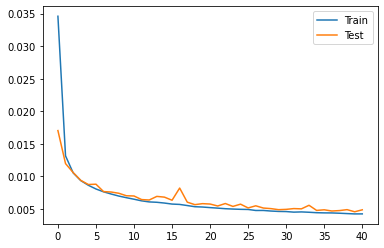

epoch 50 train loss : 0.0039293527739036336 test loss : 0.00426772503907288 epoch time : 1.4610533714294434



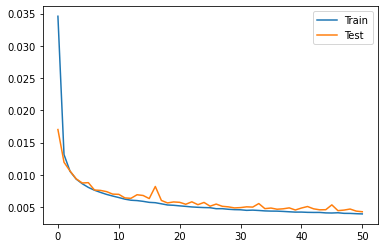

epoch 60 train loss : 0.003742867692131748 test loss : 0.004216425675839926 epoch time : 1.4573891162872314



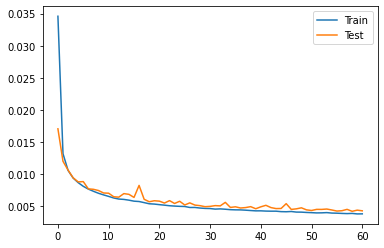

epoch 70 train loss : 0.003610413236497136 test loss : 0.003995171250154975 epoch time : 1.479191541671753



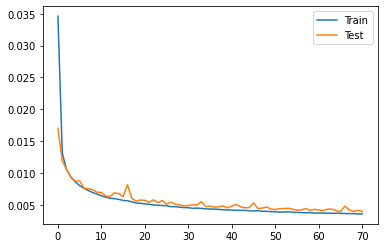

epoch 80 train loss : 0.0034552259284512427 test loss : 0.0043178228054751855 epoch time : 1.495544672012329



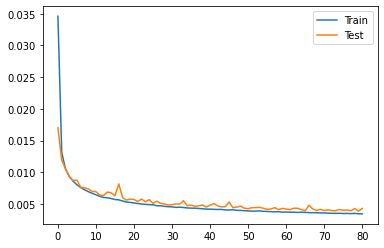

epoch 90 train loss : 0.003392251718000532 test loss : 0.003764349452175755 epoch time : 1.4772343635559082



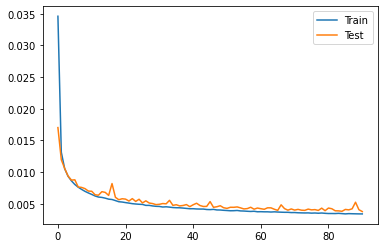

epoch 100 train loss : 0.0032783500010021747 test loss : 0.00375317264274988 epoch time : 1.5035889148712158



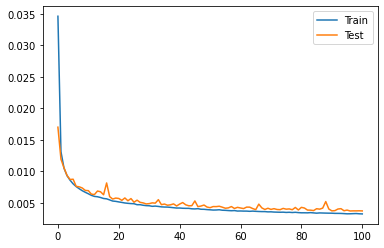

epoch 110 train loss : 0.0032158848967111515 test loss : 0.0038010253315993907 epoch time : 1.4878957271575928



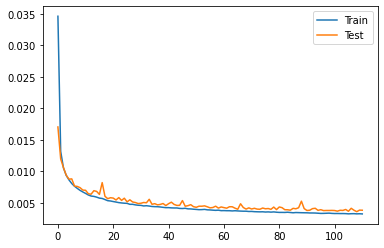

epoch 120 train loss : 0.0031475495651457127 test loss : 0.0037685357336338125 epoch time : 1.458688735961914



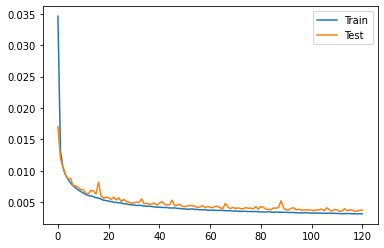

epoch 130 train loss : 0.0031088721355111786 test loss : 0.00353911887825506 epoch time : 1.489356279373169



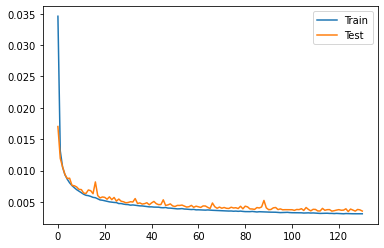

epoch 140 train loss : 0.0030277134665019573 test loss : 0.0035602143331665407 epoch time : 1.5291259288787842



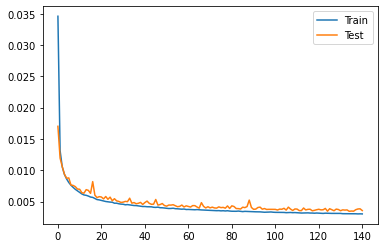

epoch 150 train loss : 0.0029972187298088204 test loss : 0.003674719535218001 epoch time : 1.5340476036071777



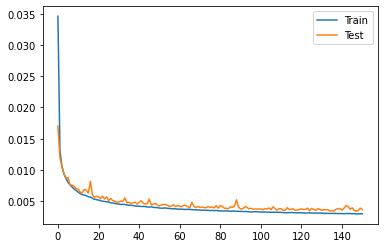

epoch 160 train loss : 0.0029462170339723073 test loss : 0.003560926812955907 epoch time : 1.5854079723358154



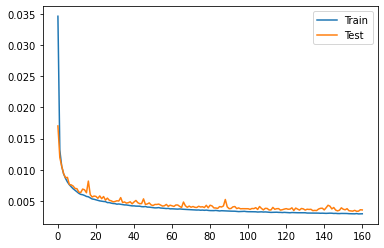

epoch 170 train loss : 0.0029007827356006964 test loss : 0.003834205004754508 epoch time : 1.4660439491271973



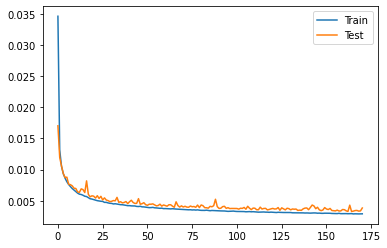

epoch 180 train loss : 0.0028329298332718023 test loss : 0.0033138869528504616 epoch time : 1.4981558322906494



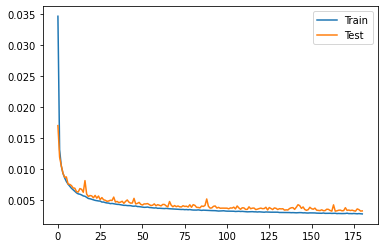

epoch 190 train loss : 0.0028273501910693493 test loss : 0.003385234498609577 epoch time : 1.4820358753204346



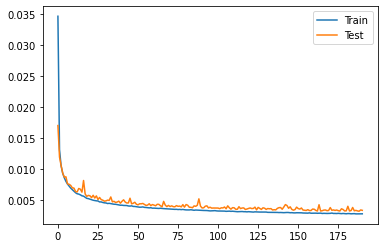

epoch 200 train loss : 0.0027940758144370283 test loss : 0.0034307950031840003 epoch time : 1.4800834655761719



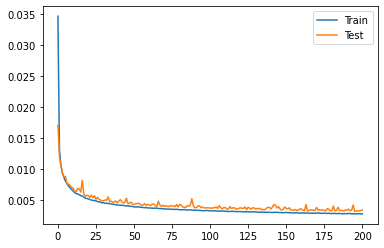

epoch 210 train loss : 0.002746617852368813 test loss : 0.003210612799778883 epoch time : 1.4683668613433838



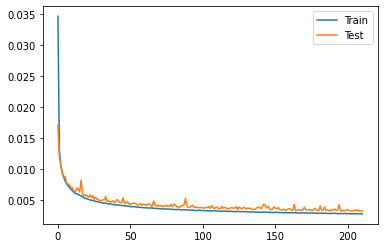

epoch 220 train loss : 0.0027315132949647107 test loss : 0.0035973748547180892 epoch time : 1.4995982646942139



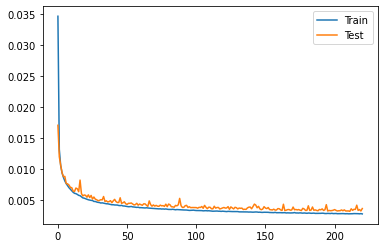

epoch 230 train loss : 0.002703700854287241 test loss : 0.003152970051628972 epoch time : 1.4579577445983887



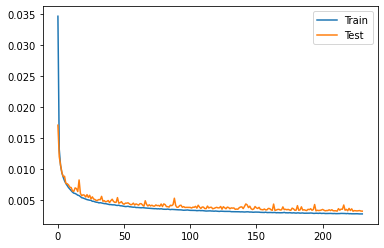

epoch 240 train loss : 0.0026713956861667255 test loss : 0.0032304420644373557 epoch time : 1.4831855297088623



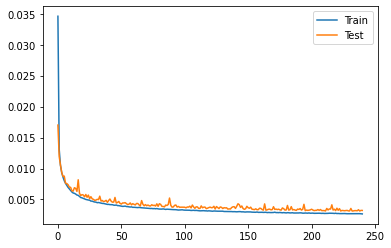

epoch 250 train loss : 0.002669280756172124 test loss : 0.0034444545561154016 epoch time : 1.469674825668335



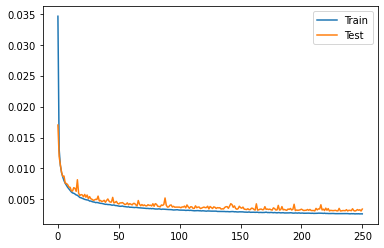

epoch 260 train loss : 0.0026499023205299077 test loss : 0.003237881728047634 epoch time : 1.4930565357208252



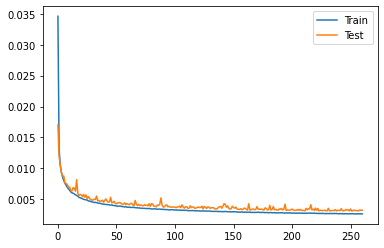

epoch 270 train loss : 0.002644515595501587 test loss : 0.0031054086601184435 epoch time : 1.4730656147003174



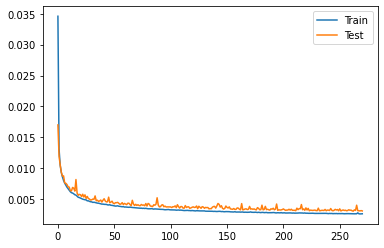

epoch 280 train loss : 0.0026023593711338644 test loss : 0.003093103256517458 epoch time : 1.5264453887939453



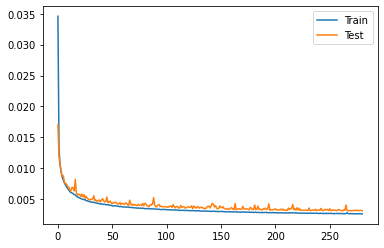

epoch 290 train loss : 0.002596161522972149 test loss : 0.0030864667347417613 epoch time : 1.4757943153381348



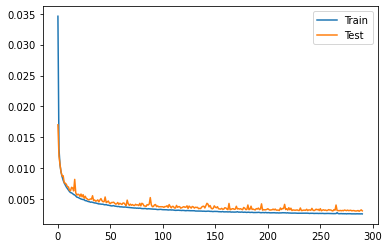

epoch 300 train loss : 0.0025665329005304075 test loss : 0.0030385792977394343 epoch time : 1.4851717948913574



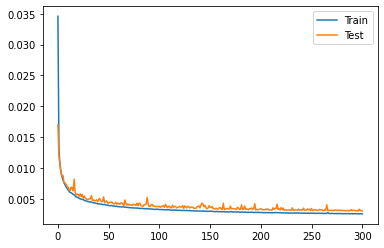

epoch 310 train loss : 0.002540903716112795 test loss : 0.003091835909994888 epoch time : 1.5333054065704346



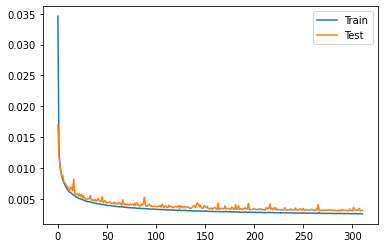

epoch 320 train loss : 0.0025501121398976267 test loss : 0.0030472839427754515 epoch time : 1.486860990524292



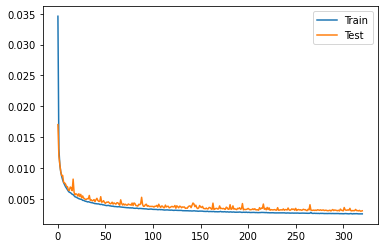

epoch 330 train loss : 0.0025273533413697072 test loss : 0.003113143495321562 epoch time : 1.5626046657562256



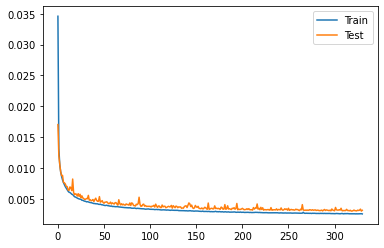

epoch 340 train loss : 0.002528383957513764 test loss : 0.0030113428876750586 epoch time : 1.514397382736206



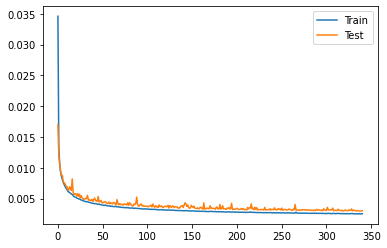

epoch 350 train loss : 0.002509994501930751 test loss : 0.0030245989776117037 epoch time : 1.4862143993377686



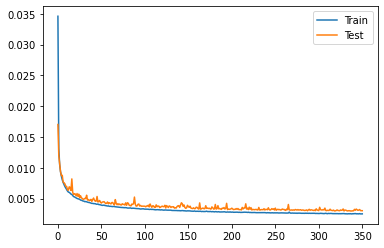

epoch 360 train loss : 0.00254701445412779 test loss : 0.0031664669534725476 epoch time : 1.4769845008850098



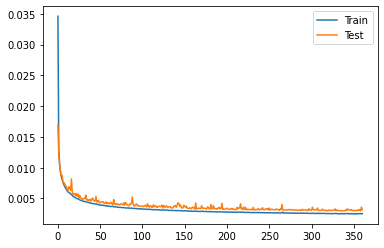

epoch 370 train loss : 0.0024896796719830654 test loss : 0.0032268164761097766 epoch time : 1.5240955352783203



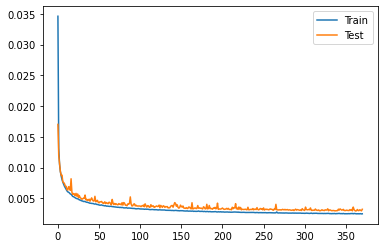

epoch 380 train loss : 0.0024736061372406435 test loss : 0.003120745577264105 epoch time : 1.4780032634735107



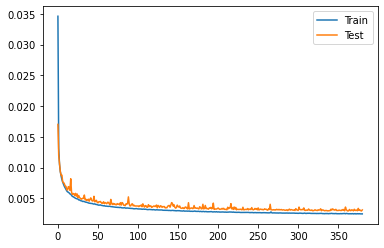

epoch 390 train loss : 0.0024714985857402835 test loss : 0.0030100444570227 epoch time : 1.4873549938201904



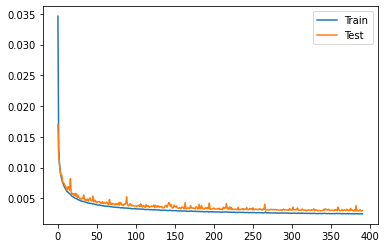

epoch 400 train loss : 0.0024509318338647433 test loss : 0.002992865527382073 epoch time : 1.4880688190460205



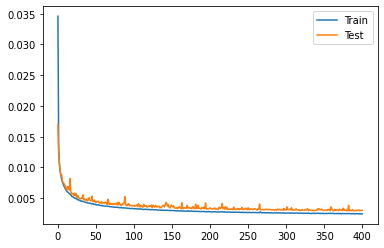

epoch 410 train loss : 0.0024464634434383003 test loss : 0.0034147916317841423 epoch time : 1.4924352169036865



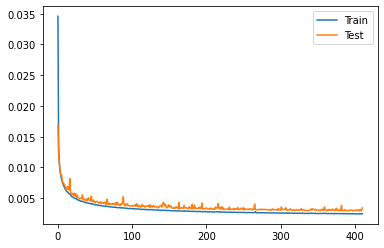

epoch 420 train loss : 0.002451389114906037 test loss : 0.002891546048005332 epoch time : 1.544381856918335



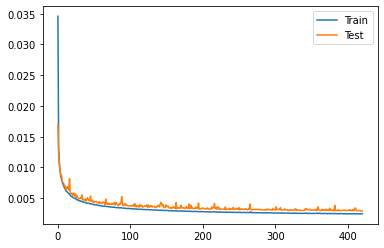

epoch 430 train loss : 0.002427212847562447 test loss : 0.003004129102074573 epoch time : 1.4986011981964111



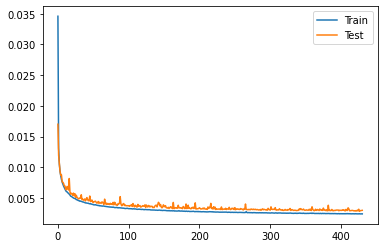

epoch 440 train loss : 0.002452001420555643 test loss : 0.0029160002257310933 epoch time : 1.473569631576538



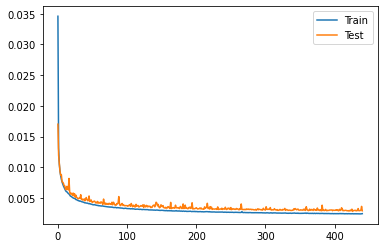

epoch 450 train loss : 0.0024276401713371172 test loss : 0.0029196198374965197 epoch time : 1.5136253833770752



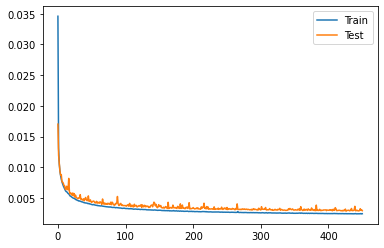

epoch 460 train loss : 0.0023996336402179294 test loss : 0.002972366992877937 epoch time : 1.5195212364196777



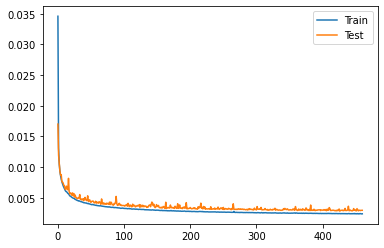

epoch 470 train loss : 0.0023792061740963376 test loss : 0.002977998386041382 epoch time : 1.4943068027496338



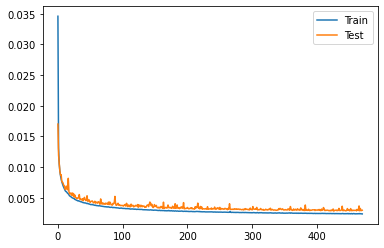

epoch 480 train loss : 0.0023879393540800044 test loss : 0.002899979480254827 epoch time : 1.5284669399261475



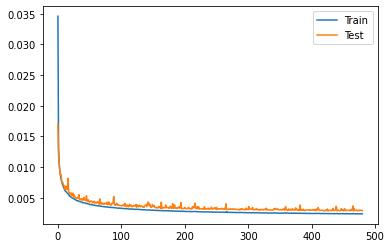

epoch 490 train loss : 0.002373567769085173 test loss : 0.0029180238926792214 epoch time : 1.5090417861938477



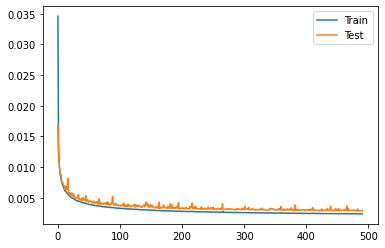

epoch 500 train loss : 0.00236651433708007 test loss : 0.0028258505731133905 epoch time : 1.476633071899414



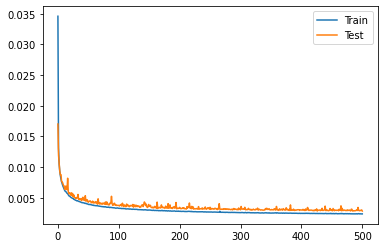

In [17]:
train_loss_list = []  
test_loss_list = []  

for i in range(501) :

    startTime = time.time()
    
    train_loss = train_epoch() #train one epoch, get the average loss
    train_loss_list.append(train_loss)
    
    test_loss = test_epoch() # test with test set
    test_loss_list.append(test_loss)
    
    epoch_time = time.time() - startTime
    
    writeString = "epoch " + str(i) + " train loss : " + str(train_loss) + " test loss : " + str(test_loss) + " epoch time : " + str(epoch_time) + "\n"
    
    # plot train/test loss graph
    if (i%10 == 0):
        plt.plot(train_loss_list, label="Train")
        plt.plot(test_loss_list, label="Test")
        plt.legend()


        
    if (i%10 == 0):
        test_samples = next(iter(test_loader))
        loss , test_output = test_batch(test_samples)
        #utils.plotPCbatch(test_samples,test_output)
        print(writeString)
        plt.show()

In [37]:
test_samples = next(iter(test_loader))
loss , test_output = test_batch(test_samples)
n = np.random.choice(test_samples.shape[0])

In [38]:

draw_pc(test_samples[n].detach().numpy())


In [39]:
draw_pc(test_output[n].detach().numpy())

In [ ]:
conv1 = torch.nn.Conv1d(3, 128, 1)

In [ ]:
input = torch.randn(100, 3, 100)

In [ ]:
conv1(input).shape

torch.Size([100, 128, 100])